# CIU execution with Boston data set and XGB model

This notebook shows how to use CIU for explaining why a residence is estimated to be expensive or not, as estimated by a Gradient Boosting model trained on the Boston Housing data set. 

We start by some necessary imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import xgboost as xgb
import ciu as ciu

Then we import and prepare the data as a Pandas DataFrame: 

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
boston_target = raw_df.values[1::2, 2]

boston_data = pd.DataFrame(data)
boston_data.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

Then we train the Gradient Boosting model: 

In [3]:
from sklearn.model_selection import train_test_split

np.random.seed(26) # We want to always get the same Random Forest model here.

X_train, X_test, y_train, y_test = train_test_split(boston_data, boston_target, test_size=0.3, random_state=123)
boston_xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
boston_xgb_model.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

Then we chooose the most expensive instance from the test set according to the XGB model for which we want to explain why it is expensive:

In [4]:
pred_test_prices = boston_xgb_model.predict(X_test)
inst_ind = np.argmax(pred_test_prices) # Test set instance with highest price estimate, so we expect a "positive" explanation.
instance = X_test.iloc[[inst_ind]]
inst_val = y_test[inst_ind]
pred = boston_xgb_model.predict(instance)[0]
print(f"Instance {inst_ind} in the test set has a real price of ${inst_val:.0f} and a predicted price of ${pred:.0f}")
print(f"The instance values are:\n{instance}")

Instance 17 in the test set has a real price of $43 and a predicted price of $34
The instance values are:
        CRIM    ZN  INDUS  CHAS    NOX    RM   AGE     DIS  RAD    TAX  \
261  0.53412  20.0   3.97   0.0  0.647  7.52  89.4  2.1398  5.0  264.0   

     PTRATIO       B  LSTAT  
261     13.0  388.37   7.26  


In order to know what is expensive and what is not, we extract the minimal and maximal prices from the training set. That also defines the "utility" of a given price, where in this case a higher price corresponds to a higher utility.

In [5]:
out_minmaxs = pd.DataFrame({'mins': [min(y_train)], 'maxs': max(y_train)})
out_minmaxs.index = ['Price']
print(f"The minimal price in the training set is ${min(y_train):.0f} and the maximal price is ${max(y_train):.0f}")

The minimal price in the training set is $5 and the maximal price is $50


Now we can go ahead and create the CIU model and get an explanation for this instance. To begin with, we just display the DataFrame that is returned by the ``explain`` method, which contains all the relevant values for a CIU result/explanation. 

In [6]:
CIU = ciu.CIU(boston_xgb_model.predict, ['Price'], data=X_train, out_minmaxs=out_minmaxs)
CIUres = CIU.explain(instance)
display(CIUres)

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
CRIM,0.056011,1.000000,0.028006,Price,34.023457,CRIM,31.502943,34.023457,[0],[0.53412],0.5,None,None
ZN,0.009911,1.000000,0.004956,Price,34.023457,ZN,33.577450,34.023457,[1],[20.0],0.5,None,None
INDUS,0.057076,1.000000,0.028538,Price,34.023457,INDUS,31.455057,34.023457,[2],[3.97],0.5,None,None
CHAS,0.000000,0.000000,-0.000000,Price,34.023457,CHAS,34.023457,34.023457,[3],[0.0],0.5,None,None
NOX,0.048834,1.000000,0.024417,Price,34.023457,NOX,31.825907,34.023457,[4],[0.647],0.5,None,None
RM,0.074986,1.000000,0.037493,Price,34.023457,RM,30.649109,34.023457,[5],[7.52],0.5,None,None
AGE,0.046000,1.000000,0.023000,Price,34.023457,AGE,31.953468,34.023457,[6],[89.4],0.5,None,None
DIS,0.051620,0.904325,0.020871,Price,34.023457,DIS,31.922781,34.245701,[7],[2.1398],0.5,None,None
RAD,0.000000,0.000000,-0.000000,Price,34.023457,RAD,34.023457,34.023457,[8],[5.0],0.5,None,None
TAX,0.043273,1.000000,0.021636,Price,34.023457,TAX,32.076191,34.023457,[9],[264.0],0.5,None,None


This becomes more "visual" as a bar plot. Since the CI values are quite small, we give a value to the ``CImax`` parameter so that the bars don't get too short. This plot illustrates the CU ("how good") value using a red-to-green color scale. The color scale can be changed with the ``color_blind`` parameter. 

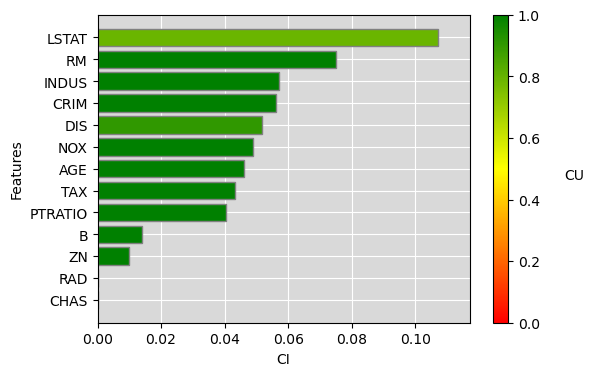

In [7]:
CIU.plot_ciu(CIUres, CImax=min(1.0,(max(CIUres.CI)+0.01)))

An alternative way of visualising CIU is to use the ``'overlap'``plot mode, which shows the CI value as a transparent bar and the CU value as a solid bar within the CI bar. CU=0 produces no solid bar, while CU=1 produces a solid bar that covers the transparent bar entirely. This can be seen as a kind of "what-if" explanation because the bars with the biggest transparent areas are the ones where changing the value has the greatest potential effect on the output value. 

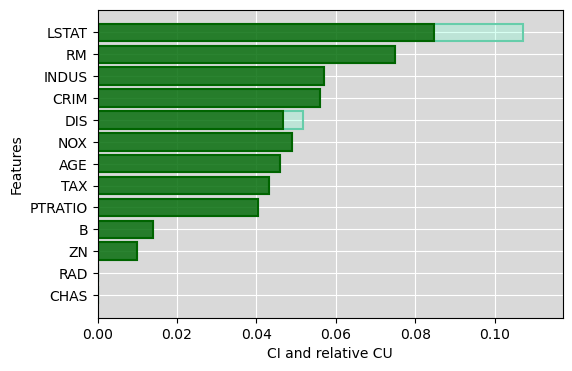

In [8]:
CIU.plot_ciu(CIUres, plot_mode='overlap', CImax=min(1.0,(max(CIUres.CI)+0.01)))

The way in which CI and CU values are calculated for one feature can be plotted and studied with the ``plot_input_output`` method:

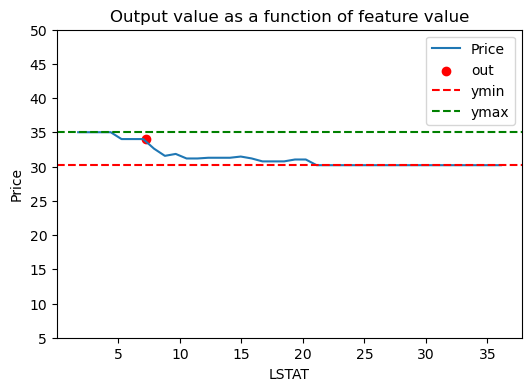

In [9]:
CIU.plot_input_output(ind_input=12, illustrate_CIU=True)

However, this expensive instance is slightly "boring", so we check out what it looks like for an average-price residence

Instance 1 in the test set has a real price of $27 and a predicted price of $26
The instance values are:
       CRIM   ZN  INDUS  CHAS    NOX    RM   AGE     DIS  RAD    TAX  PTRATIO  \
85  0.05735  0.0   4.49   0.0  0.449  6.63  56.1  4.4377  3.0  247.0     18.5   

        B  LSTAT  
85  392.3   6.53  


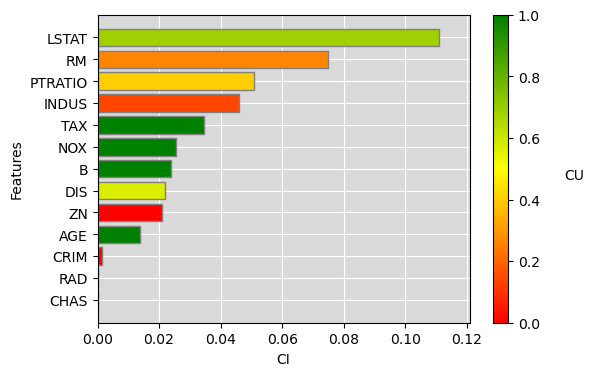

In [10]:
inst_ind = 1
instance = X_test.iloc[[inst_ind]]
inst_val = y_test[inst_ind]
pred = boston_xgb_model.predict(instance)[0]
print(f"Instance {inst_ind} in the test set has a real price of ${inst_val:.0f} and a predicted price of ${pred:.0f}")
print(f"The instance values are:\n{instance}")
CIUres = CIU.explain(instance)
CIU.plot_ciu(CIUres, CImax=min(1.0,(max(CIUres.CI)+0.01)))

Same using ``overlap``:

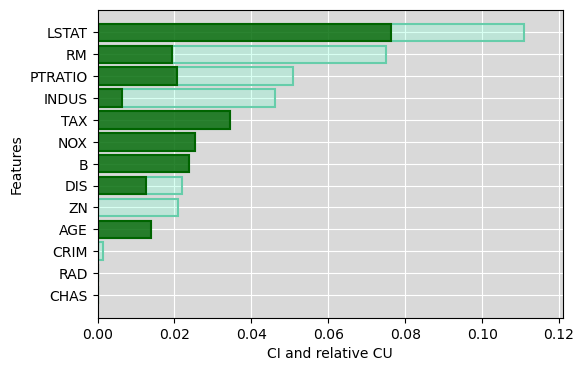

In [11]:
CIU.plot_ciu(CIUres, plot_mode='overlap', CImax=min(1.0,(max(CIUres.CI)+0.01)))

It is also possible to use "Contextual influence" values for producing a similar plot as is often used for LIME and Shapley values. Here, the ``neutralCU`` parameter of CIU determines what to use as the "baseline/reference value". The default value ``neutralCU=0.5`` signifies "averagely good" but it can be set to any value that makes sense for the application at hand. 

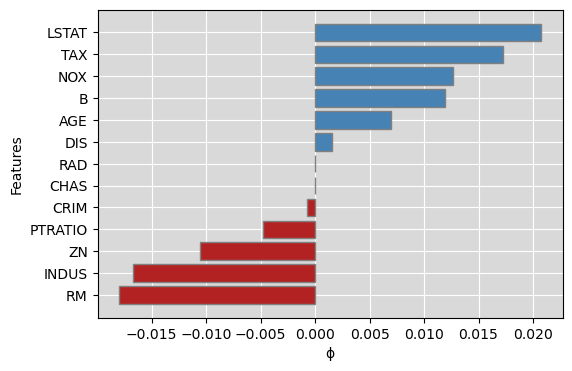

In [12]:
CIU.plot_influence(CIUres)

For direct comparison with Shapley values, ``neutralCU`` should be set to the CU values that corresponds to the average output value. For Boston, this could be done like this:

0.3947080979284369


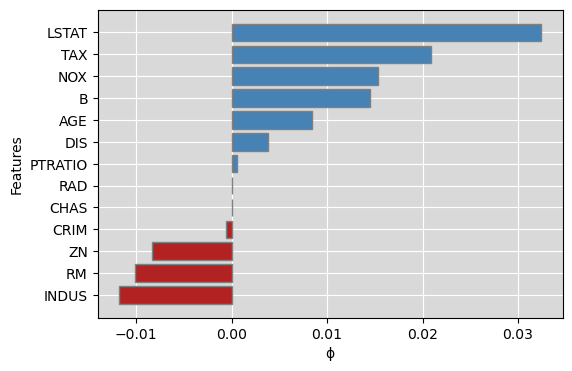

In [13]:
avg_price = np.mean(y_train)
neutralCU = (avg_price - out_minmaxs.mins)/(out_minmaxs.maxs - out_minmaxs.mins)
print(neutralCU[0])
CIUres_shap = CIU.explain(instance, neutralCU=neutralCU[0])
CIU.plot_influence(CIUres_shap)

A ``neutralCU=0.395`` value is obviously lower than ``neutralCU=0.5``. This is because the majority of instances have a price that is lower than ``5 + (50-5)/2=27.5`` that corresponds to ``neutralCU=0.5``. ``neutralCU=0.395`` corresponds to a price of ``5 + 0.395x(50-5)=22.8``. This is an important information to communicate to the user in order to interpret and understand the explanation correctly!

Let's see what SHAP gives as a result. In the CIU plot we have used the same colors as LIME usually does but SHAP uses the opposite colors, which might sometimes be confusing. However, the negative or positive influences are clear from the direction of the bars. 

[14:28:31] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


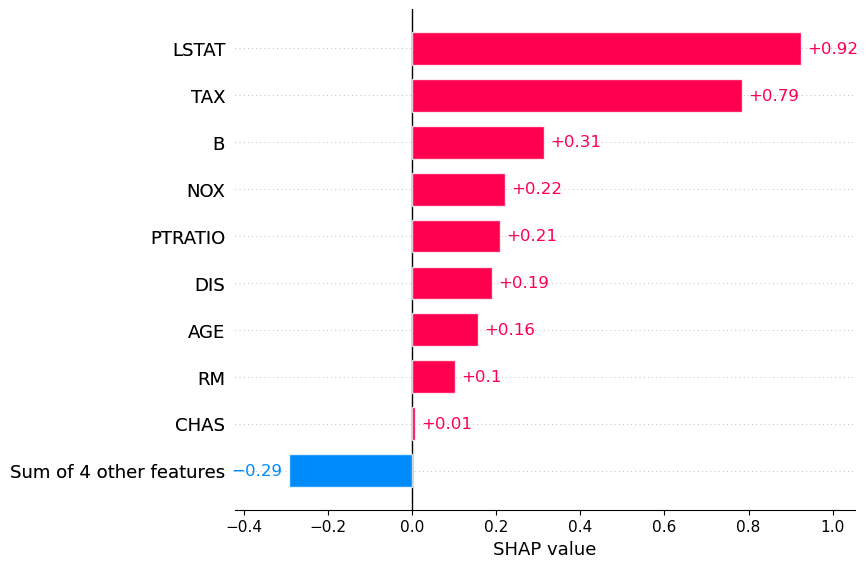

In [14]:
import shap
explainer = shap.Explainer(boston_xgb_model, X_train)
shap_values = explainer(instance)
shap.plots.bar(shap_values[0,:], order=np.argsort(shap_values[0,:].values)[::-1])

In [15]:
print(CIU.textual_explanation(CIUres))

The explained value is Price with the value 25.57 (CU=0.46), which is lower than average utility.
Feature CRIM has very low importance (CI=0.00) and has value(s) 0.05735, which is low utility (CU=0.00)
Feature ZN has very low importance (CI=0.02) and has value(s) 0.0, which is low utility (CU=0.00)
Feature INDUS has very low importance (CI=0.05) and has value(s) 4.49, which is low utility (CU=0.14)
Feature CHAS has very low importance (CI=0.00) and has value(s) 0.0, which is low utility (CU=0.00)
Feature NOX has very low importance (CI=0.03) and has value(s) 0.449, which is high utility (CU=1.00)
Feature RM has very low importance (CI=0.07) and has value(s) 6.63, which is lower than average utility (CU=0.26)
Feature AGE has very low importance (CI=0.01) and has value(s) 56.1, which is high utility (CU=1.00)
Feature DIS has very low importance (CI=0.02) and has value(s) 4.4377, which is higher than average utility (CU=0.57)
Feature RAD has very low importance (CI=0.00) and has value(s) 

In [16]:
from IPython.display import Markdown
markdown_text = CIU.textual_explanation(CIUres, use_markdown_effects=True)
Markdown(markdown_text)

The explained value is ***Price*** with the value 25.57 (CU=0.46), which is **lower than average utility**.<br>Feature *CRIM* has **very low importance (CI=0.00)** and has value(s) 0.05735, which is **low utility (CU=0.00)**<br>Feature *ZN* has **very low importance (CI=0.02)** and has value(s) 0.0, which is **low utility (CU=0.00)**<br>Feature *INDUS* has **very low importance (CI=0.05)** and has value(s) 4.49, which is **low utility (CU=0.14)**<br>Feature *CHAS* has **very low importance (CI=0.00)** and has value(s) 0.0, which is **low utility (CU=0.00)**<br>Feature *NOX* has **very low importance (CI=0.03)** and has value(s) 0.449, which is **high utility (CU=1.00)**<br>Feature *RM* has **very low importance (CI=0.07)** and has value(s) 6.63, which is **lower than average utility (CU=0.26)**<br>Feature *AGE* has **very low importance (CI=0.01)** and has value(s) 56.1, which is **high utility (CU=1.00)**<br>Feature *DIS* has **very low importance (CI=0.02)** and has value(s) 4.4377, which is **higher than average utility (CU=0.57)**<br>Feature *RAD* has **very low importance (CI=0.00)** and has value(s) 3.0, which is **low utility (CU=0.00)**<br>Feature *TAX* has **very low importance (CI=0.03)** and has value(s) 247.0, which is **high utility (CU=1.00)**<br>Feature *PTRATIO* has **very low importance (CI=0.05)** and has value(s) 18.5, which is **lower than average utility (CU=0.41)**<br>Feature *B* has **very low importance (CI=0.02)** and has value(s) 392.3, which is **high utility (CU=1.00)**<br>Feature *LSTAT* has **very low importance (CI=0.11)** and has value(s) 6.53, which is **higher than average utility (CU=0.69)**<br>